In [5]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# 1. Fake data

In [2]:
M = 200
N = 50

X = np.linspace(0, 1, M)
Y = np.linspace(0, 1, N)
XX, YY = np.meshgrid(X, Y)

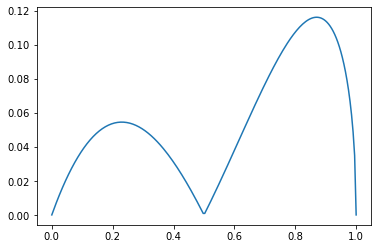

In [3]:
def f1(x): return np.sqrt(-x**2*(x-1/2)**2*(x-1))

plt.plot(X, f1(X))

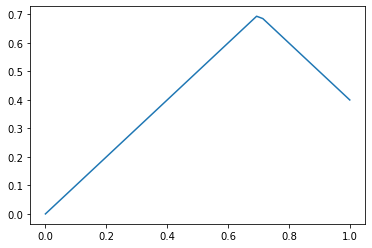

In [4]:
c = 0.7
def f2(y): return -abs(y-c) + c

plt.plot(Y, f2(Y))

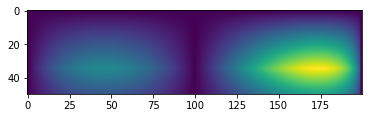

In [5]:
def γ(x,y): return f1(x)*f2(y)

Γ = γ(XX,YY)
plt.imshow(Γ)

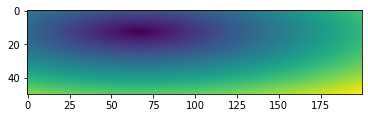

In [6]:
def d(x,p): return cp.norm(x-p)
def d_(x,p): return np.linalg.norm(x-p)

x = np.array([1/3,1/4])
D = [d_(x,(X[i],Y[j])) for i in range(M) for j in range(N)]

plt.imshow(np.transpose(np.reshape(D, (M, N))))

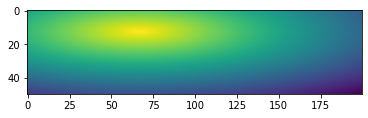

In [7]:
#k = 3
#def s(d): return cp.exp(-k*d)
#def s_(d): return np.exp(-k*d)
def s(d): return -d
def s_(d): return -d

S = [s_(d_(x,(X[i],Y[j]))) for i in range(M) for j in range(N)]

plt.imshow(np.transpose(np.reshape(S, (M, N))))

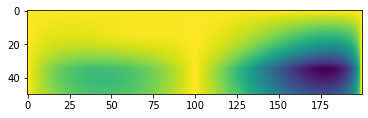

In [9]:
SΓ = [s_(d_(x,(X[i],Y[j])))*γ(X[i],Y[j]) for i in range(M) for j in range(N)]

plt.imshow(np.transpose(np.reshape(SΓ, (M, N))))

In [10]:
x_pb = cp.Variable(2)
f_obj = cp.sum([s(d(x_pb,(X[i],Y[j])))*γ(X[i],Y[j]) for i in range(M) for j in range(N)])

In [11]:
f_obj

Expression(CONCAVE, NONPOSITIVE, ())

In [12]:
pb = cp.Problem(cp.Maximize(f_obj), [x_pb[0] >= 0, x_pb[1] >= 0, x_pb[0] <= 1, x_pb[1] <= 1])

In [13]:
pb.solve()

-74.57509652715012

In [14]:
x_pb.value

array([0.68832863, 0.63436701])

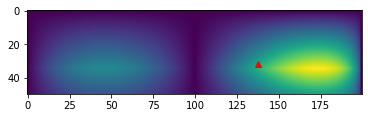

In [15]:
plt.imshow(Γ)
plt.plot(x_pb.value[0]*M, x_pb.value[1]*N, marker = '^', color = 'red')

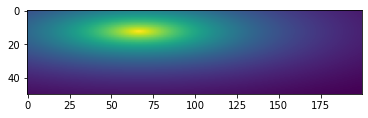

In [16]:
k = 3
def s(d): return cp.exp(-k*d)
def s_(d): return np.exp(-k*d)
#def s(d): return -d
#def s_(d): return -d

S = [s_(d_(x,(X[i],Y[j]))) for i in range(M) for j in range(N)]

plt.imshow(np.transpose(np.reshape(S, (M, N))))

# 2: Real-world data

- We will use real-world demographic data taken from LandScan [1].


- The desired information pertaining to the population of the city of Rio de Janeiro has been extracted by the ModSiming team from UFRJ [2].

[1] https://landscan.ornl.gov/

[2] https://github.com/ModSiming/EpiSiming

## 2.1: Data

In [2]:
landscan_rio = np.load('landscan_rio_paqueta.npy').astype(int)
landscan_rio = np.maximum(landscan_rio, 0)
landscan_rio_xscale = 0.85239
landscan_rio_yscale = 0.926
landscan_rio_ydim, landscan_rio_xdim = landscan_rio.shape
landscan_rio_xextent = landscan_rio_xdim*landscan_rio_xscale
landscan_rio_yextent = landscan_rio_ydim*landscan_rio_yscale

print(f'Dimensão da matriz de blocos: {landscan_rio.shape}')
print('Região representada pelo LandScan: ',
      f'{landscan_rio_xextent:.3f} x {landscan_rio_yextent:.3f} km^2')
print(f'Total de blocos: {landscan_rio_xdim*landscan_rio_ydim}')
print(f'Total de blocos habitados: {len(landscan_rio[landscan_rio>0])}')
print(f'População: {landscan_rio.sum()}')

Dimensão da matriz de blocos: (39, 83)
Região representada pelo LandScan:  70.748 x 36.114 km^2
Total de blocos: 3237
Total de blocos habitados: 1473
População: 6860819


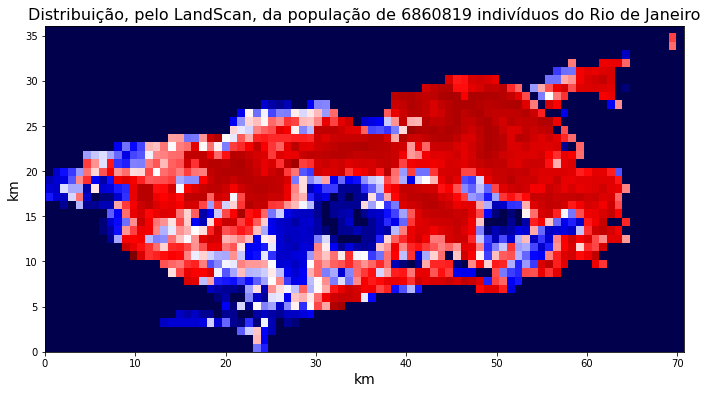

In [3]:
plt.figure(figsize=(12,6))
plt.imshow(np.log(1 + landscan_rio), cmap='seismic', interpolation='none',
           extent=[0,landscan_rio_xextent,0,landscan_rio_yextent])
plt.grid(False)
plt.xlabel('km', fontsize=14)
plt.ylabel('km', fontsize=14)
plt.title(f'Distribuição, pelo LandScan, da população de {int(landscan_rio.sum())} indivíduos do Rio de Janeiro',
          fontsize=16)
plt.show()

## 2.2: Linear signal decay (concave objective function)

In [6]:
var = cp.Variable(2)

res_x_1 = (var[0] >= 0); res_x_2 = (var[0] <= landscan_rio_xdim-1)
res_y_1 = (var[1] >= 0); res_y_2 = (var[1] <= landscan_rio_ydim-1)
res = [res_x_1, res_x_2, res_y_2, res_y_2]

def d(p,q): return cp.norm(p-q)
def s(d): return -d

f_obj = cp.sum([s(d(var,[x,y])) * landscan_rio[y,x] for x in range(landscan_rio_xdim) for y in range(landscan_rio_ydim)])

pb = cp.Problem(cp.Maximize(f_obj), res)
pb.solve()

-106788693.5100656

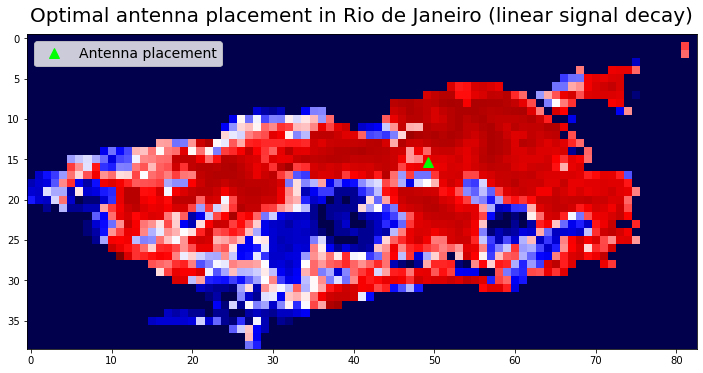

In [7]:
plt.figure(figsize=(12,6))
plt.imshow(np.log(1 + landscan_rio), cmap = 'seismic')
plt.plot(var[0].value, var[1].value, '^', color = 'lime', markersize = 10, label = "Antenna placement")
plt.title("Optimal antenna placement in Rio de Janeiro (linear signal decay)", fontsize = 20, y = 1.02)
plt.legend(loc = 'upper left', fontsize = 14)
plt.show()

## 2.3: Exponential signal decay (non-convex/concave objetive funtion)

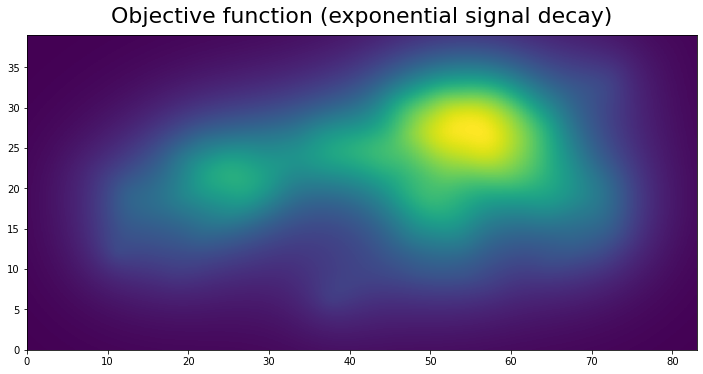

In [9]:
def d(p,q): return np.linalg.norm(p-q, axis = 1)
c = 0.25
def s(d): return np.exp(-c*d)

pts_x = np.array(range(landscan_rio_xdim))
pts_y = np.array(range(landscan_rio_ydim))
pts_x_meshgrid, pts_y_meshgrid = np.meshgrid(pts_x, pts_y)
all_pts = np.column_stack((pts_x_meshgrid.ravel(), pts_y_meshgrid.ravel()))
    
def f(px,py):
    p = np.array([px,py])
    return np.sum(s(d(p,all_pts)) * landscan_rio.ravel())

M = 200
N = 200
X = np.linspace(0, landscan_rio_xdim, M)
Y = np.linspace(0, landscan_rio_ydim, N)

F = np.transpose(np.reshape([f(x,y) for x in X for y in Y], (M,N)))

plt.figure(figsize=(12,6))
plt.imshow(F, extent = [0, landscan_rio_xdim, 0, landscan_rio_ydim])
plt.title("Objective function (exponential signal decay)", fontsize = 22, y = 1.02);

In [ ]:
var = cp.Variable(2)

res_x_1 = (var[0] >= 0); res_x_2 = (var[0] <= landscan_rio_xdim-1)
res_y_1 = (var[1] >= 0); res_y_2 = (var[1] <= landscan_rio_ydim-1)
res = [res_x_1, res_x_2, res_y_2, res_y_2]

def d(p,q): return cp.norm(p-q)
def s(d): return cp.exp(d)

f_obj = cp.sum([s(d(var,[x,y])) * landscan_rio[y,x] for x in range(landscan_rio_xdim) for y in range(landscan_rio_ydim)])

pb = cp.Problem(cp.Maximize(f_obj), res)
pb.solve()